In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd gdrive/MyDrive/Colab Notebooks/CITS5553

/content/gdrive/MyDrive/Colab Notebooks/CITS5553


In [ ]:
!pip install timeshap

In [5]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('')
# sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

import tensorflow as tf

# Data Preparation

In [7]:
# t0_df = pd.read_csv(df_final)
path_t0_df = ROOT_DIR / 'data/Model input data/t4_sequence.csv'
t0_df = pd.read_csv(path_t0_df)# t0_df

admission_t0 = t0_df[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    admission_t0.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission_t0['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission_t0['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
X_t0_train = t0_df.merge(X_t0_train[['SUBJECT_ID', 'HADM_ID']])
X_t0_train['count'] = X_t0_train.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
X_train_count = X_t0_train.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_t0_train = X_t0_train.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

X_t0_test = t0_df.merge(X_t0_test[['SUBJECT_ID', 'HADM_ID']])
X_t0_test['count'] = X_t0_test.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
X_test_count = X_t0_test.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_t0_test = X_t0_test.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

# # If you want to get the train and test set as dataframes:
train_t0_df = X_t0_train.drop(['count'], axis=1)
test_t0_df = X_t0_test.drop(['count'], axis=1)

# remove unrelated columns
X_t0_train = X_t0_train.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'count'])
X_t0_test = X_t0_test.drop(columns=["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'count'])

In [8]:
# Feature scaling - Standardisation
scaler = StandardScaler()

X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

In [9]:
def ts_to_secs(X, X_count, Y):
    # X = X.T
    act_secs_labels = tf.one_hot(Y, 2)
    # act_secs_labels = Y.values

    number_of_secs = X_train_count.shape[0]
    secs_data = []

    k=0
    for i in X_count:
        secs_data.append(X[k:k+i, :])
        k = k+i

    secs_data = tf.ragged.constant(secs_data)
    # act_secs_labels = np.array(act_secs_labels)
    # act_secs_labels = tf.ragged.constant(act_secs_labels)
    return secs_data, act_secs_labels


In [10]:
def data_preparation():
  ## This Variable Defines the Size of Sliding Window
  ## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor)
  # w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
  ## Here We Choose Step Size for Building Different Snapshots from Time-Series Data
  ## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
  # s = 10
  train_data, act_train = ts_to_secs(X_t0_train, X_train_count, y_t0_train)

  # s = 10
  test_data, act_test = ts_to_secs(X_t0_test, X_test_count, y_t0_test)


  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [11]:
train_data, y_train, test_data, y_test = data_preparation()
act_label = ['NON-SEPSIS', 'SEPSIS']

[INFO] -- Shape of Training Sections:
tf.Tensor([36932     9    32], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9233    8   32], shape=(3,), dtype=int64)


# Model Training t4

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

max_seq = train_data.bounding_shape()[-1]
def LSTM_model():
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, 32], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         82432     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 25)                8

In [13]:
def get_class_weights():
  label_counts = y_t0_train.value_counts()
  label_proportions = label_counts / len(y_t0_train)*100
  # Calculate class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  return class_weights

get_class_weights()

{0: 1.1207, 1: 9.2841}

In [14]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4.hdf5', save_best_only = True, monitor='mse', mode='min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', patience = 10, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]
m = model.fit(train_data, y_train,
              class_weight=get_class_weights(),
              epochs=50, batch_size=64, verbose=1,
               callbacks=callbacks_list)

Epoch 1/50
578/578 [==============================] - 20s 22ms/step - loss: 0.3995 - mse: 0.2076
Epoch 2/50
  1/578 [..............................] - ETA: 42s - loss: 0.3989 - mse: 0.2189

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 11s 19ms/step - loss: 0.3725 - mse: 0.1892
Epoch 3/50
578/578 [==============================] - 11s 19ms/step - loss: 0.3690 - mse: 0.1863
Epoch 4/50
578/578 [==============================] - 11s 19ms/step - loss: 0.3654 - mse: 0.1858
Epoch 5/50
578/578 [==============================] - 11s 19ms/step - loss: 0.3623 - mse: 0.1848
Epoch 6/50
578/578 [==============================] - 10s 17ms/step - loss: 0.3601 - mse: 0.1836
Epoch 7/50
578/578 [==============================] - 12s 21ms/step - loss: 0.3587 - mse: 0.1831
Epoch 8/50
578/578 [==============================] - 11s 19ms/step - loss: 0.3581 - mse: 0.1822
Epoch 9/50
578/578 [==============================] - 11s 19ms/step - loss: 0.3564 - mse: 0.1821
Epoch 10/50
578/578 [==============================] - 10s 17ms/step - loss: 0.3540 - mse: 0.1800
Epoch 11/50
578/578 [==============================] - 10s 17ms/step - loss: 0.3517 - mse: 0.1804
Epoch 12/50
578/578 [==================

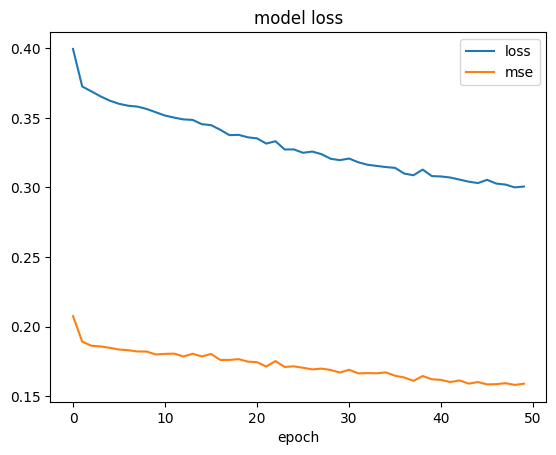

In [15]:
import matplotlib.pyplot as plt
plt.plot(m.history['loss'])
plt.plot(m.history['mse'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','mse'], loc='upper right')
plt.show()

In [20]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [16]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

289/289 [==============================] - 2s 7ms/step
AUC = 0.7697


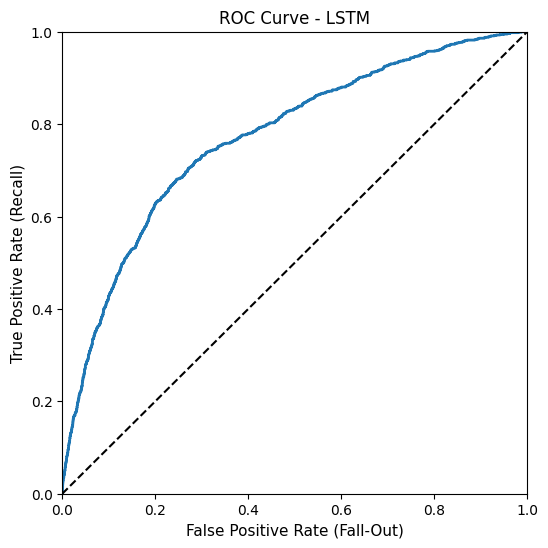

In [22]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(test_data)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
# fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_test, y_pred, pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [18]:
def print_results(M, X_train, Y_train, X_test, Y_test):
    # np.set_printoptions(suppress=True)
    # result1 = M.evaluate(X, Y, verbose = 2)
    # act_acc = np.round(result1[1]*100,2)
    # print("***[RESULT]*** ACT Accuracy: "+str(act_acc))
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    preds_train = M.predict(X_train)
    preds_train = np.argmax(preds_train, axis=1)
    conf_mat_train = confusion_matrix(Y_train, preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    preds_test = np.argmax(preds_test, axis=1)
    conf_mat_test = confusion_matrix(Y_test, preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])

    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    f1_train = f1_score(Y_train, preds_train)
    f1_test = f1_score(Y_test, preds_test)
    acc_train = balanced_accuracy_score(Y_train, preds_train)
    acc_test = balanced_accuracy_score(Y_test, preds_test)
    # Computing precision and recall
    precision_train = precision_score(Y_train, preds_train)
    precision_test = precision_score(Y_test, preds_test)
    recall_train = recall_score(Y_train, preds_train)
    recall_test = recall_score(Y_test, preds_test)
    # table = pd.DataFrame({'F1-Score':[f1_train, f1_test], 'Balanced Acc':[acc_train, acc_test],
    #                      'Precision':[precision_train, precision_test], 'Recall':[recall_train, recall_test]},
    #                      index=['Train', 'Test'])

    table = pd.DataFrame({'Train':[acc_train, precision_train, recall_train, f1_train], 'Test':[acc_test, precision_test, recall_test, f1_test]},
                         index=['Balanced Acc', 'Precision', 'Recall', 'F1-Score'])
    print(table)

289/289 [==============================] - 1s 5ms/step
***[RESULT]*** ACT  Confusion Matrix


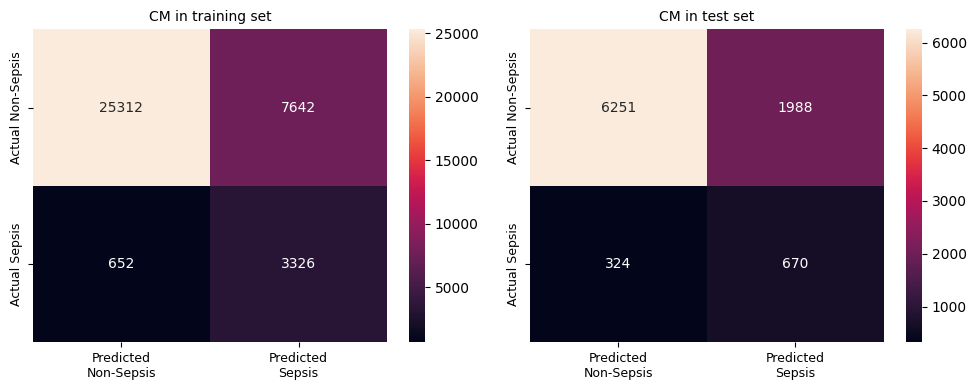

                 Train      Test
Balanced Acc  0.802100  0.716376
Precision     0.303246  0.252069
Recall        0.836099  0.674044
F1-Score      0.445069  0.366922


In [21]:
print_results(model, train_data, y_train, test_data, y_test)

# TimeSHAP

Model entry point

In [20]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = train_t0_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,4])]

In [21]:
d_train_normalized = pd.concat([train_t0_df, pd.DataFrame(X_t0_train, columns=model_features)], axis=1)
d_test_normalized = pd.concat([test_t0_df, pd.DataFrame(X_t0_test, columns=model_features)], axis=1)

Baseline event

In [22]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [42]:
average_event

,p_AGE_normalize,p_GENDER_NUM_normalize,p_ITEMID_50804_normalize,p_ITEMID_50813_normalize,p_ITEMID_50818_normalize,p_ITEMID_50820_normalize,p_ITEMID_50821_normalize,p_ITEMID_50862_normalize,p_ITEMID_50863_normalize,p_ITEMID_50878_normalize,...,p_ITEMID_51244_normalize,p_ITEMID_51248_normalize,p_ITEMID_51256_normalize,p_ITEMID_51265_normalize,p_ITEMID_51274_normalize,p_ITEMID_51275_normalize,p_ITEMID_51277_normalize,p_ITEMID_51279_normalize,p_ITEMID_51301_normalize,p_ITEMID_51493_normalize
0,0.187396,-0.850357,-0.842224,-0.848199,-0.842027,-0.890172,-0.832588,-0.501391,-0.611267,-0.482339,...,-0.913225,0.713598,-0.91318,0.562068,0.887343,0.898833,0.715028,0.715364,0.702611,-0.298054


In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

Average score over baseline

In [23]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [44]:
model.predict(test_data).shape

289/289 [==============================] - 2s 5ms/step


(9233, 2)

In [ ]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

## Local Explanations

In [133]:
ids_for_test = [183628, 116009, 107064, 109235] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [25]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [26]:
plot_feats_1 = {x:x[12:] for x in model_features[:2]}
plot_feats_2 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[2:]}
plot_feats = {**plot_feats_1, **plot_feats_2}

In [130]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [134]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1000/1000 [==============================] - 2s 2ms/step


In [135]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

alt.VConcatChart(...)

## Global Explanation

In [75]:
d_test_normalized['timestamp'] = d_test_normalized.groupby(['SUBJECT_ID', 'HADM_ID']).cumcount()
d_test_normalized.timestamp = d_test_normalized.timestamp.astype(int)

In [143]:
from timeshap.explainer import prune_all, pruning_statistics, event_explain_all, feat_explain_all
from timeshap.plot import plot_global_event, plot_global_feat

pos_dataset = d_test_normalized
schema = list(pos_dataset.columns)
time_feat = 'timestamp'

In [ ]:
pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
prun_indexes = prune_all(f, pos_dataset, pruning_dict, average_event, model_features, schema, sequence_id_feat, time_feat)
# pruning_stats = pruning_statistics(prun_indexes, pruning_dict.get('tol'))
# pruning_stats

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 26s 26s/step


In [78]:
# prun_indexes = pd.read_csv('prun_all_tf.csv')
prun_indexes

In [1]:
event_dict = {'rs': 42, 'nsamples': 32000}
event_data = event_explain_all(f, pos_dataset, event_dict, prun_indexes, average_event, model_features, schema, sequence_id_feat, time_feat)
event_global_plot = plot_global_event(event_data)
event_global_plot

NameError: ignored